# Material point response of nonlinear membrane models

$\newcommand{\bG}{\boldsymbol{G}}
\newcommand{\bC}{\boldsymbol{C}}
\newcommand{\bCel}{\boldsymbol{C}_\text{el}}
\newcommand{\bx}{\boldsymbol{x}}
\newcommand{\bu}{\boldsymbol{u}}
\newcommand{\bsig}{\boldsymbol{\sigma}}
\newcommand{\bF}{\boldsymbol{F}}
\newcommand{\bS}{\boldsymbol{S}}
\newcommand{\bU}{\boldsymbol{U}}
\newcommand{\bV}{\boldsymbol{V}}
\newcommand{\bW}{\boldsymbol{W}}
\newcommand{\bZ}{\boldsymbol{Z}}
\newcommand{\T}{^\text{T}}
\newcommand{\bLambda}{\boldsymbol{\Lambda}}$

In this demo, we validate the implementation of the non-linear Ogden membrane model at the material point level.  We simulate the response of a material point by prescribing an affine displacement field on the boundary:
\begin{equation}
\bu = \overline{\bG}\cdot\bx \quad \text{on }\partial\Omega 
\end{equation}
with an imposed displacement gradient of the form:
\begin{equation}
\overline{\bG} = \begin{bmatrix}
\delta_x & \gamma \\ 0 & \delta_y
\end{bmatrix} \Rightarrow \bC = \begin{bmatrix}
(1+\delta_x)^2 & \gamma(1+\delta_x) \\ \gamma(1+\delta_x) & (1+\delta_y)^2+\gamma^2
\end{bmatrix}
\end{equation}
where $\delta_x$ (resp. $\delta_y$) is a horizontal (resp. vertical) elongation and $\gamma$ a shear distortion. These specific boundary conditions induce a uniform deformation state that is $\bG=\nabla \bu = \overline{\bG}$ inside $\Omega$.

## Stresses

The principal true (or Cauchy) stresses in the incompressible case for a plane-stress membrane ($\sigma_3=0$) are then given by:
\begin{equation}
\sigma_i = \lambda_i\dfrac{\partial \hat\psi}{\partial \lambda_i} = \dfrac{2\mu}{\alpha}\left(\lambda_i^\alpha - \dfrac{1}{\lambda_1^\alpha\lambda_2^\alpha}\right), \quad i=1,2 \label{eq:membrane-stress-theoretical}
\end{equation}

In our numerical implementation, the stress is recovered from the Lagrange multiplier associated with the SDP constraint $\bZ\succeq 0$. Indeed, one can easily show from SDP duality that the latter dual variable $\bLambda_{\bZ}$  is a block-matrix which is also positive:
\begin{equation}
\bLambda_{\bZ} = \begin{bmatrix}
\bLambda_{\bU} & \bLambda_{\bV} \\ \bLambda_{\bV}\T & \bLambda_{\bW}
\end{bmatrix} \succeq 0
\end{equation}
and that one has at the optimum:
\begin{equation}
\bLambda_{\bU} = \dfrac{\partial \psi}{\partial \bC}(\bCel) \succeq 0
\end{equation}
which gives the Piola-Kirchhoff stress $\bS$ up to a factor 2. The Cauchy stress is then obtained with $\bsig = \bF\bS\bF\T$ ($J=1$).

In [2]:
from ufl import grad, as_matrix, Identity
from dolfin import (
    RectangleMesh,
    Point,
    FunctionSpace,
    VectorFunctionSpace,
    TensorFunctionSpace,
    DirichletBC,
    Constant,
    project,
    assemble,
    dx,
    Expression,
)
from fenics_optim import (
    MosekProblem,
    to_mat,
)
import numpy as np
import matplotlib.pyplot as plt
from ogden_membrane import OgdenMembrane

def material_point_response(Gimp, alpha):
    """Compute material point response to a given imposed displacement gradient."""
    mu = Constant(1.0)

    mesh = RectangleMesh(Point(0, 0), Point(1.0, 1.0), 1, 1)
    V = VectorFunctionSpace(mesh, "CG", degree=1, dim=2)

    # homogeneous deformation bcs
    Uimp = Expression(
        ("Gxx*x[0]+Gxy*x[1]", "Gyx*x[0]+Gyy*x[1]"),
        Gxx=Gimp[0, 0],
        Gxy=Gimp[0, 1],
        Gyx=Gimp[1, 0],
        Gyy=Gimp[1, 1],
        degree=1,
    )
    bc = DirichletBC(V, Uimp, "on_boundary")

    prob = MosekProblem("No-compression membrane model")
    u = prob.add_var(V, bc=bc)

    G = grad(u)
    energy = OgdenMembrane(grad(u), mu, alpha, degree=1)
    prob.add_convex_term(energy)

    prob.parameters["log_level"] = 0
    prob.optimize()

    t = prob.get_var("t")
    s = prob.get_var("s")

    # recover principal stretches from t and s
    lambda1 = project(
        (t + s[0]) ** 0.5,
        FunctionSpace(mesh, "DG", 0),
        form_compiler_parameters={"quadrature_degree": energy.degree},
    )
    lambda2 = project(
        (t - s[0]) ** 0.5,
        FunctionSpace(mesh, "DG", 0),
        form_compiler_parameters={"quadrature_degree": energy.degree},
    )

    # recover stress from Lagrange multiplier
    S = -2 * to_mat(prob.get_lagrange_multiplier("Stress"))
    F = Identity(2) + G
    VS = TensorFunctionSpace(mesh, "DG", 0, shape=(2, 2))
    sigma = project(
        F * as_matrix([[S[0, 0], 1 / 2 * S[0, 1]], [1 / 2 * S[1, 0], S[1, 1]]]) * F.T,
        VS,
        form_compiler_parameters={"quadrature_degree": energy.degree},
    )
    sigma.rename("Cauchy stress", "")
    return prob.pobj, u, lambda1, lambda2, sigma

The obtained solution is then compared against the reference analytical expression. Note that the latter is valid only for tensile states $\sigma_1,\sigma_2 > 0$.

In [3]:
alpha = 3.5

Uimp_list = np.linspace(-0.5, 1, 21)
eps_y = 0.05
delta = 0.5

ener = []
lambda_num = []
sig_num = []
for eps_x in Uimp_list:
    G = np.array([[eps_x, delta], [0, eps_y]])
    pobj, u, lambda1, lambda2, sigma = material_point_response(G, alpha)

    lambda_num.append([lambda1.vector()[0], lambda2.vector()[0]])
    sig_i, _ = np.linalg.eig(sigma.vector()[:4].reshape((2, 2)))
    sig_i.sort()
    sig_num.append(sig_i[::-1])
    ener.append(
        assemble(
            2
            / alpha ** 2
            * (
                lambda1 ** alpha
                + lambda2 ** alpha
                + 1 / lambda1 ** alpha / lambda2 ** alpha
                - 3
            )
            * dx
        )
    )

lambda_num = np.asarray(lambda_num)
sig_num = np.asarray(sig_num)


eps_x = Uimp_list
l1 = np.sqrt(
    1
    / 2
    * (
        (1 + eps_x) ** 2
        + ((1 + eps_y) ** 2 + delta ** 2 )
        + np.sqrt(
            ((1 + eps_x) ** 2 - (1 + eps_y) ** 2 - delta ** 2) ** 2
            + 4 * delta ** 2 * (1 + eps_x) ** 2
        )
    )
)
l2 = np.sqrt(
    1
    / 2
    * (
        (1 + eps_x) ** 2
        + ((1 + eps_y) ** 2 + delta ** 2)
        - np.sqrt(
            ((1 + eps_x) ** 2 - (1 + eps_y) ** 2 - delta ** 2) ** 2
            + 4 * delta ** 2 * (1 + eps_x) ** 2
        )
    )
)
ener_th = 2 / alpha ** 2 * (l1 ** alpha + l2 ** alpha + 1 / l1 ** 2 / l2 ** 2 - 3)

sig_1 = 2 / alpha * (l1 ** alpha - 1 / ((l1 * l2)) ** alpha)
sig_2 = 2 / alpha * (l2 ** alpha - 1 / ((l1 * l2)) ** alpha)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


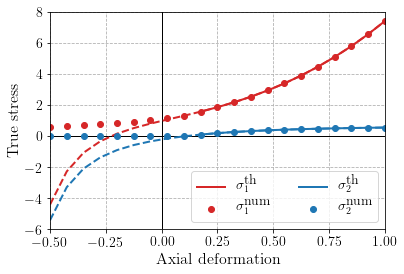

In [4]:
pos = np.logical_and(sig_1 >= -1e-4, sig_2 >= -1e-4)

plt.figure()
plt.axvline(0, color="k", linewidth=1)
plt.axhline(0, color="k", linewidth=1)
plt.plot(Uimp_list, sig_1, "--C3")
plt.plot(Uimp_list[pos], sig_1[pos], "-C3", label=r"$\sigma_1^\textrm{th}$")
plt.plot(
    Uimp_list, sig_num[:, 0], "oC3", linewidth=1, label=r"$\sigma_1^\textrm{num}$"
)
plt.plot(Uimp_list, sig_2, "--C0")
plt.plot(Uimp_list[pos], sig_2[pos], "-C0", label=r"$\sigma_2^\textrm{th}$")
plt.plot(
    Uimp_list, sig_num[:, 1], "oC0", linewidth=1, label=r"$\sigma_2^\textrm{num}$"
)
plt.xlabel("Axial deformation", fontsize=16)
plt.ylabel("True stress", fontsize=16)
plt.legend(ncol=2)
plt.savefig(f"results_alpha_{alpha}_eps_y_{eps_y}_delta_{delta}.pdf")
plt.show()

defo = np.array([[eps_x, eps_y, delta] for eps_x in Uimp_list])

lambda_th = np.vstack((l1, l2, sig_1, sig_2, ener_th)).T
results = np.concatenate(
    (defo, lambda_num, sig_num, np.array([ener]).T, lambda_th), axis=1
)
header = "eps_x, eps_y, delta, lambda_1_num, lambda_2_num, sig_1_num,\
            sig_2_num, ener_num, lambda_1_th, \
            lambda_2_th, sig_1_th, sig_2_th, ener_th"
np.savetxt(
    f"results_alpha_{alpha}_eps_y_{eps_y}_delta_{delta}.csv",
    results,
    delimiter=",",
    header=header,
)

The figure reports the evolution of both principal true stresses as a function of an imposed axial elongation $\varepsilon_x$ in a combined elongation and shear case $\varepsilon_y=0.05$, $\delta=0.5$. One can see that the numerical tension field results match exactly with the theoretical expression in regions where both $\sigma_1,\sigma_2 > 0$ (solid lines). In the remaining region where the analytical $\sigma_2 \leq 0$, the numerical tension field stresses deviate from the theoretical expession (dashed lines) and yields a pure tension state with $\sigma_2=0$ and $\sigma_1>0$ which corresponds to wrinkles having formed along principal direction 2.